###  https://github.com/jonbruner/tensorflow-basics/blob/master/save-load/save.ipynb

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

## PUT MODELS IN DIFFERENT FILES AND SAVE THEM
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pylab
from random import randint


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
train_digits, train_labels = mnist.train.images[:], mnist.train.labels[:]
test_digits, test_labels = mnist.test.images[:], mnist.test.labels[:]

In [4]:
def add_gaussian_noise(digit, mean, stddev):
    ''' 
    This function adds gaussian noise to the matrix representations
    of the mnist digit
    IN:   
        (1) np array: the MNIST digit representations (n, 784)
        (2) float: the mean of the Gaussian to sample noise from
        (3) float: the standard deviation of the Gaussian to sample
            noise from. Note that the range of pixel values is
            0-255; 
    OUT: 
        (1) np array: noisy training data (n, 784)
    '''
    # #of images (55500 for mnist)
    n_imgs = digit.shape[0]
    # matrix size (784 for mnist)
    n_size = digit.shape[1]
    if stddev == 0:
        noise = np.zeros((n_imgs, n_size))
    else:
        # sample from normal dist
        noise = np.random.normal(mean, stddev/255.,(n_imgs, n_size))
    # add the noise to the data
    x_noisy = digit + noise
    # make sure all data points are in interval [0, 1]
    x_noisy = np.clip(x_noisy, 0., 1.)
    return x_noisy

noise_stddevs = np.linspace(0, 192, 97)
stddevs = noise_stddevs[::8]

x_noisy_test = np.zeros([len(stddevs), len(test_digits), 784])
for i in range(len(stddevs)):
    x_noisy_test[i] = add_gaussian_noise(test_digits[:], 0, stddevs[i])

In [5]:
x_noisy_train = np.zeros([len(stddevs), len(train_digits), 784])
for i in range(len(stddevs)):
    x_noisy_train[i] = add_gaussian_noise(train_digits[:], 0, stddevs[i])

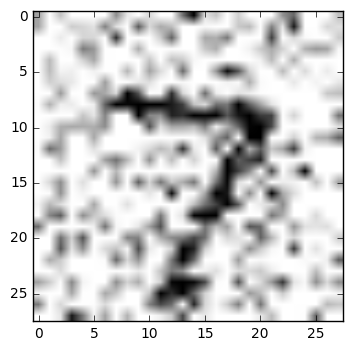

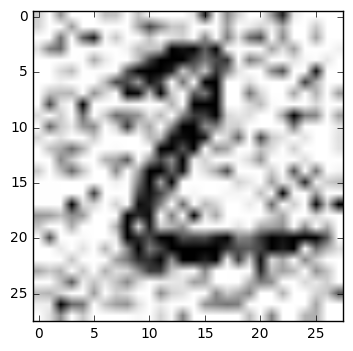

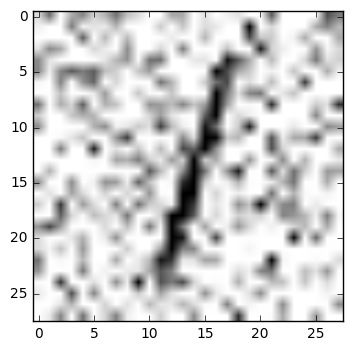

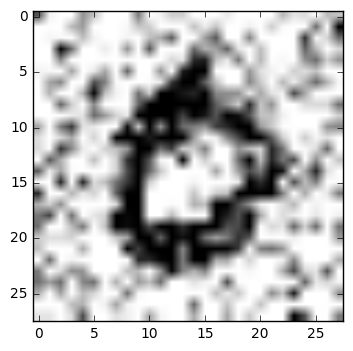

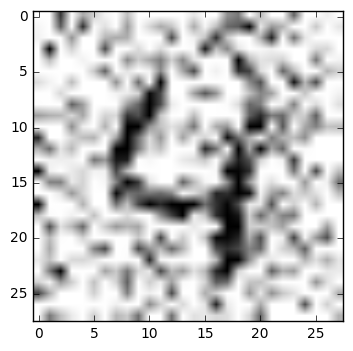

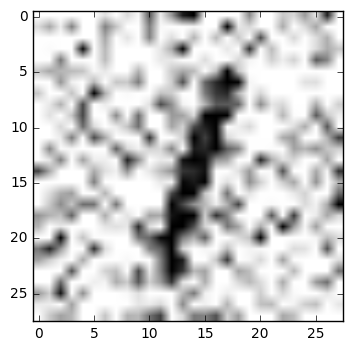

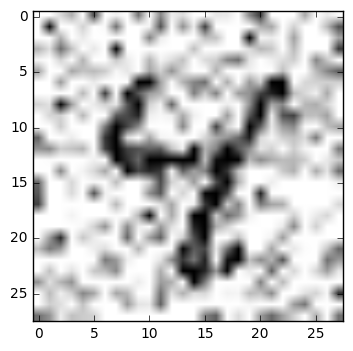

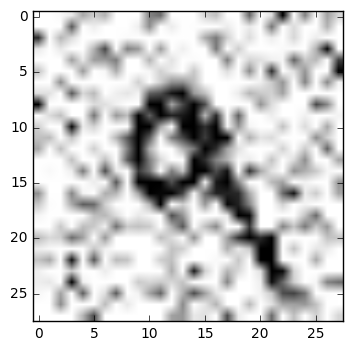

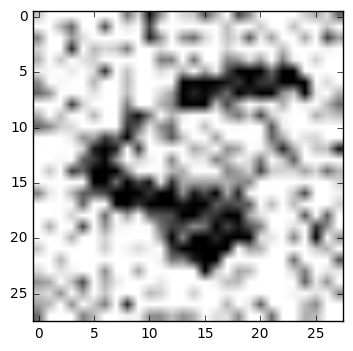

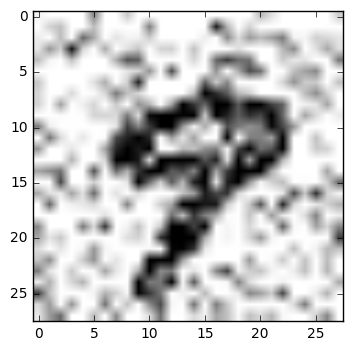

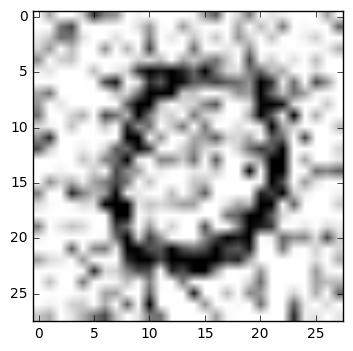

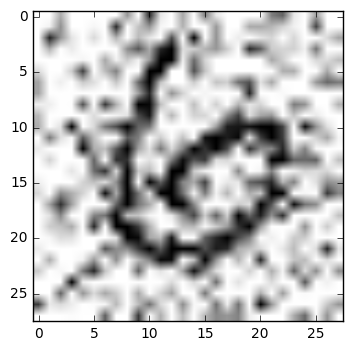

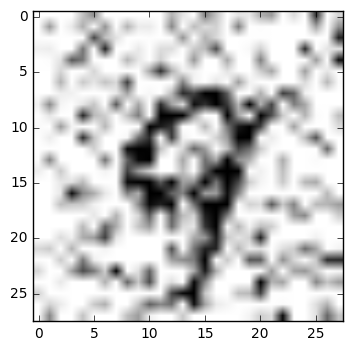

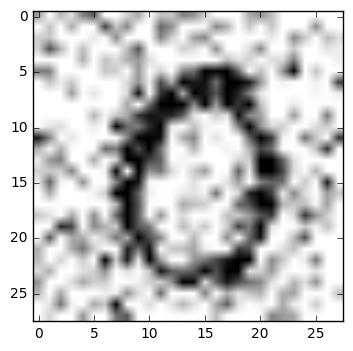

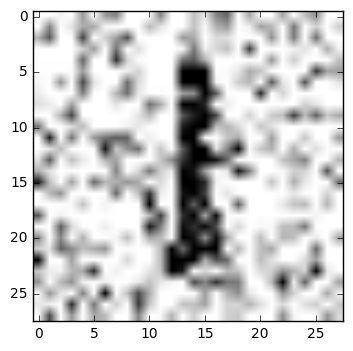

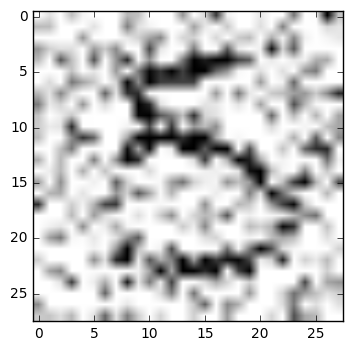

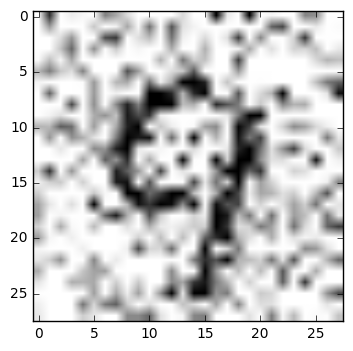

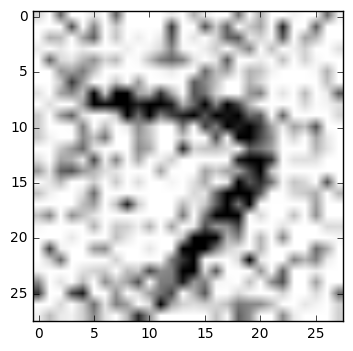

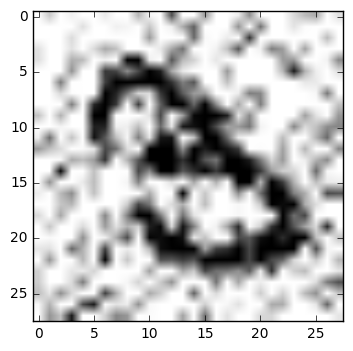

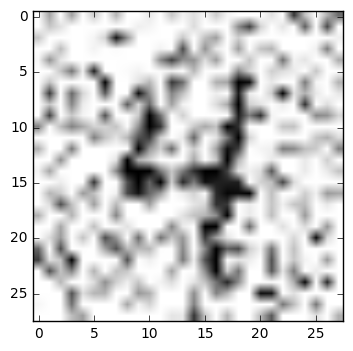

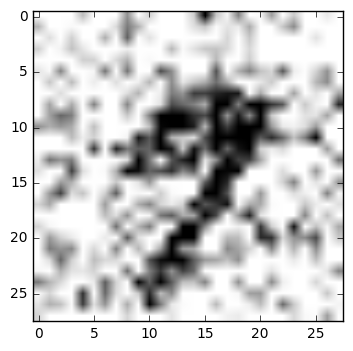

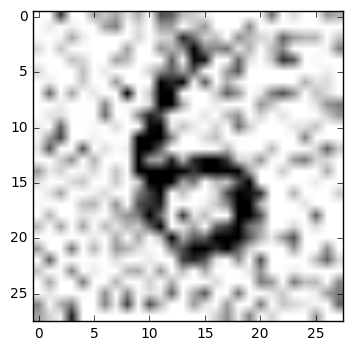

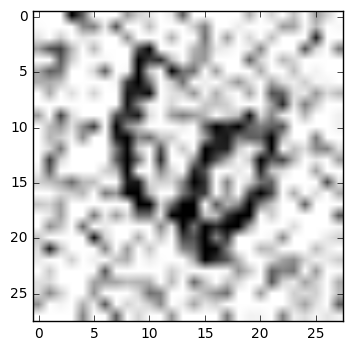

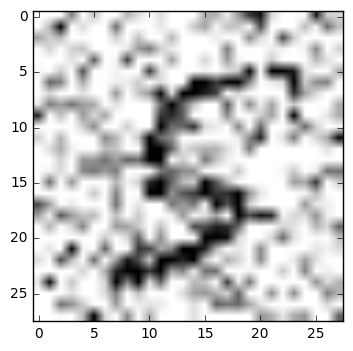

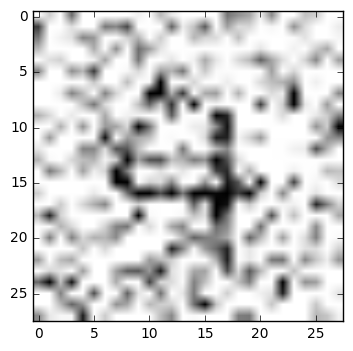

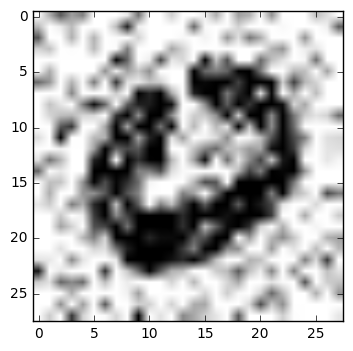

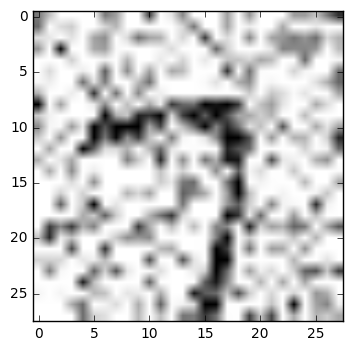

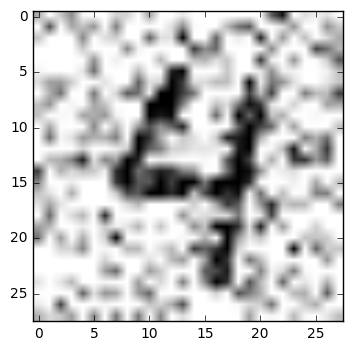

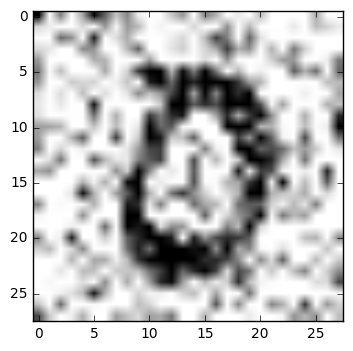

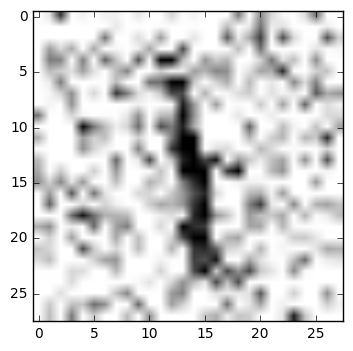

In [27]:
for i in range(30):
    plt.imshow(x_noisy_test[6][i].reshape([28,28]), cmap=plt.get_cmap('binary'))
    plt.show()

In [5]:
def add_blob_occlusion(mnist_digits, occ_perc):
    ''' 
    This function adds occlusions to the matrix representations
    of the mnist digits
    IN:   
        (1) np array: the MNIST digit representations (n, 784)
        (2) float: percentage of occlusion after OReilly [0, 1]
    OUT: 
        (1) np array: occluded training data (n, 784)
        
    From O'REILLY et al. 
    The blob-based occlusion algorithm involved the construction of a 
    filter that was set to 1.0 within a circle of radius 5% of the image size 
    (i.e., 5% of 144 pixels or 7 pixels) and then fell off outside   
    
    '''
    # img is 28x28 pixels
    n = 28
    n_apply = 2.5 * occ_perc * (n / (n/20.00) + 1) + 0.5
    # print "applying " + str(int(n_apply)) + " filters"
    # copy because we are going to modify them.
    occluded_digits = np.copy(mnist_digits)
    counter = 0
    for digit in occluded_digits:
        # plt.imshow(mnist_digits[counter].reshape(n,n), cmap = cm.Greys)
        # plt.show()
        # reshape to size n,n
        occluded_digit = digit.reshape(n,n)
        for i in range(int(n_apply)):
            # randint is inclusive
            # make (2, n-r)
            r = 2 # floor(28/20) = 1.4 # Zeiler 144/20 = 7.2
            a = randint(0,n)
            b = randint(0, n)
            # the coordinates
            y,x = np.ogrid[-a:n-a, -b:n-b]
            # create the circular mask
            mask = x*x + y*y <= r*r
            
            # GAUSSIAN HERE??
            # without gaussian you could potentially create new features.
            
            array = np.zeros((n, n))
            # set all values to -1 (neg numbers clipped later)
            array[mask] = -1
            # add the negative values (1-1 = 0 so the max is occluded as well)
            # could also need a gaussian fall off here
            occluded_digit = occluded_digit+array
            # make it in range 0,1 so negative numbers become 0. 
            occluded_digit = np.clip(occluded_digit, 0., 1.)
        
        # set the occluded digit in the nparray
        occluded_digits[counter] = occluded_digit.reshape(784,)
        counter+=1;
   
    return occluded_digits

In [ ]:
occ_percs = np.linspace(0,1,11)
x_occ_test = np.zeros([len(occ_percs), len(test_digits), 784])
for i in range(len(occ_percs)):
    x_occ_test[i] = add_blob_occlusion(test_digits[:], occ_percs[i])
    

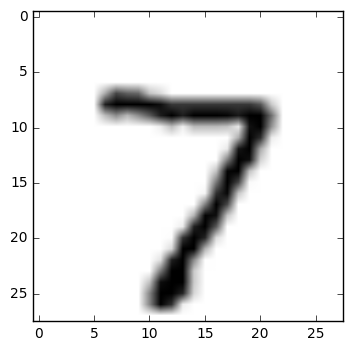

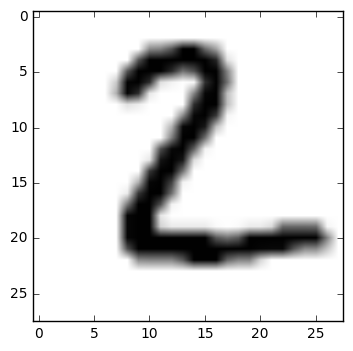

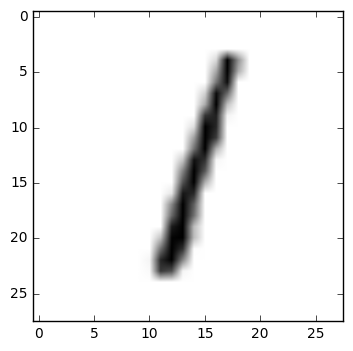

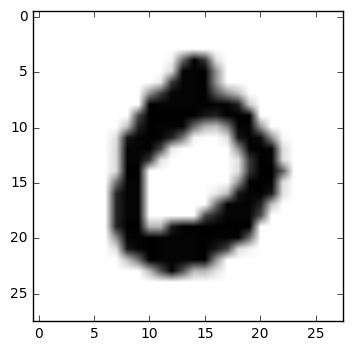

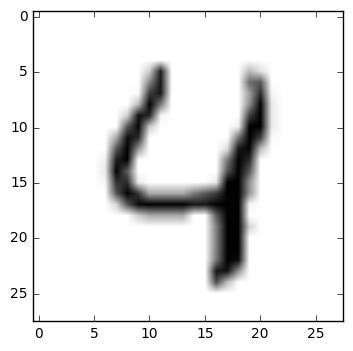

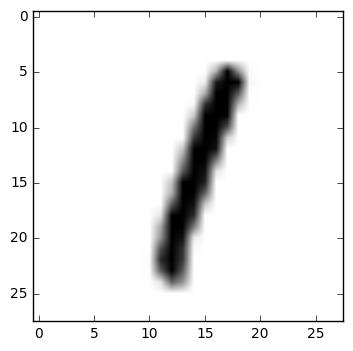

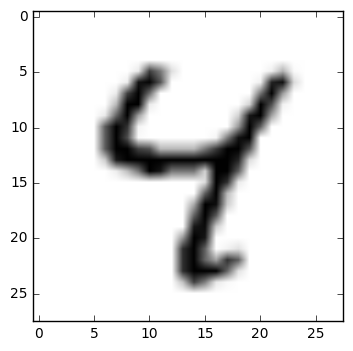

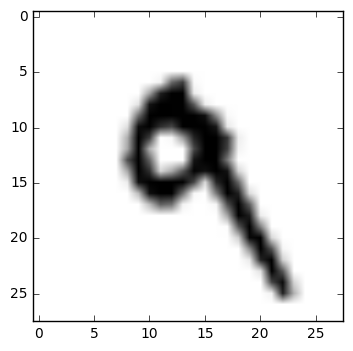

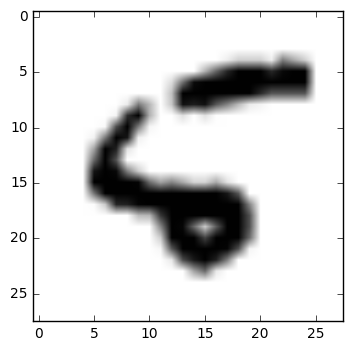

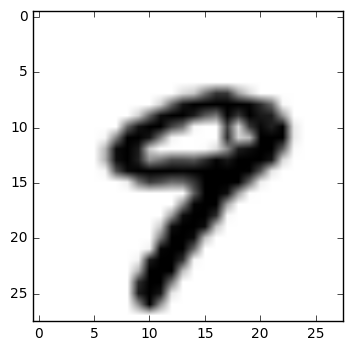

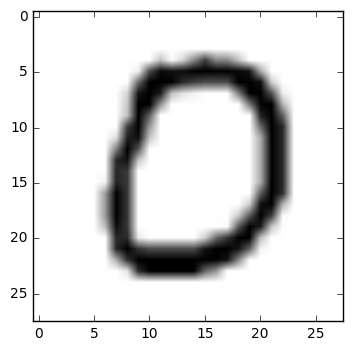

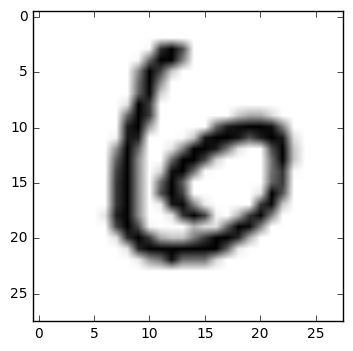

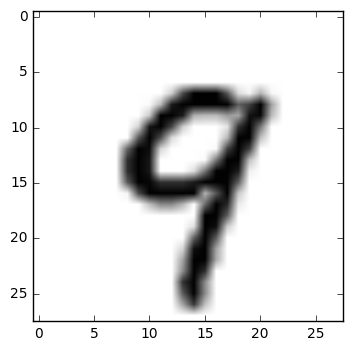

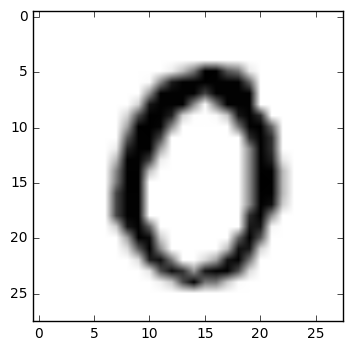

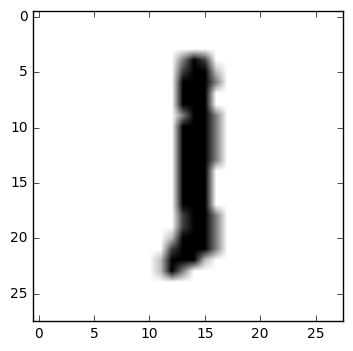

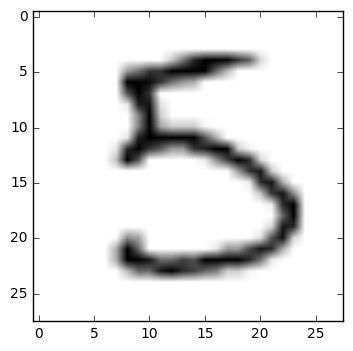

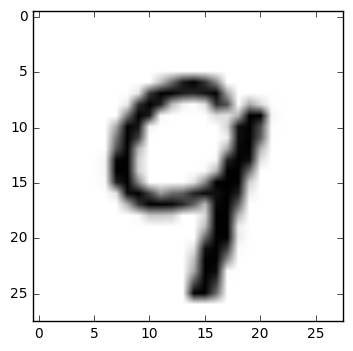

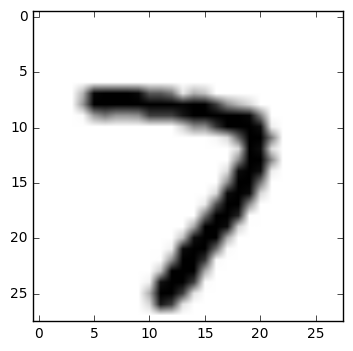

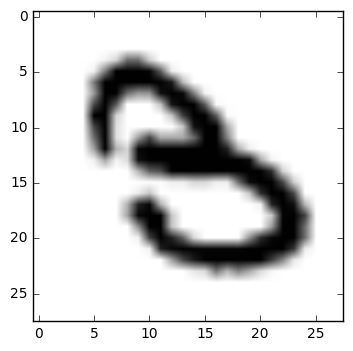

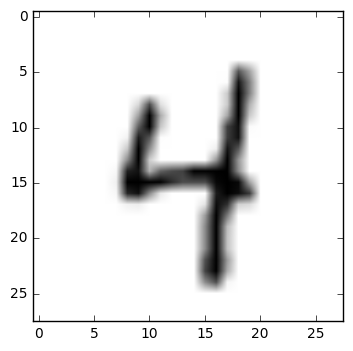

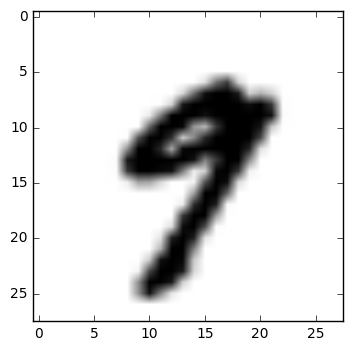

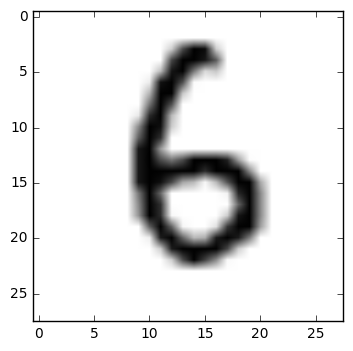

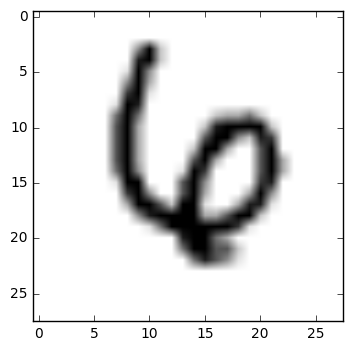

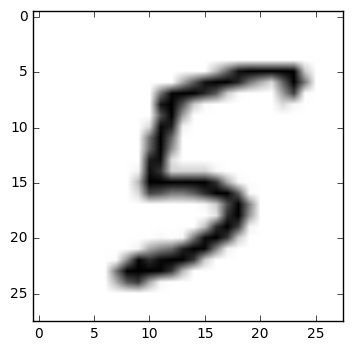

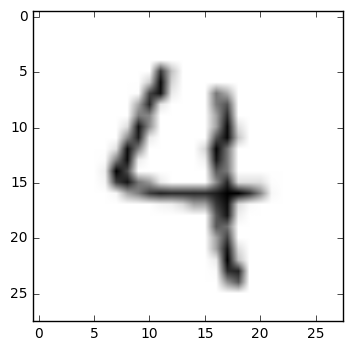

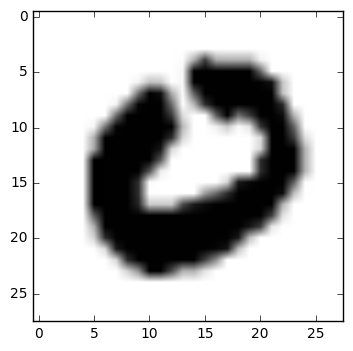

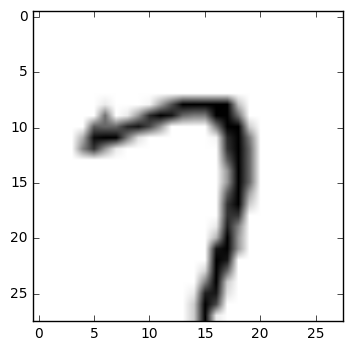

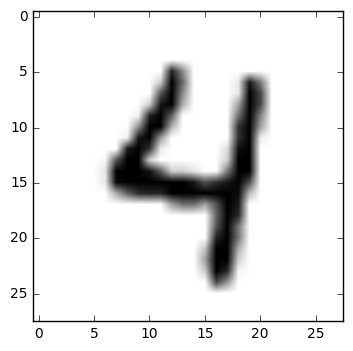

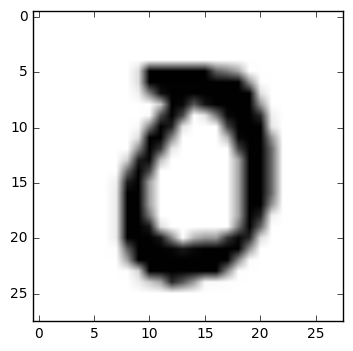

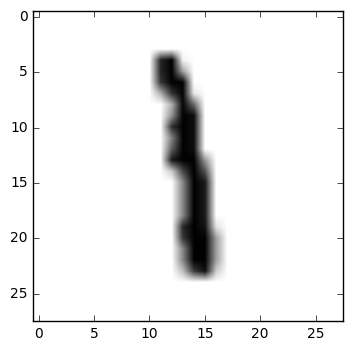

In [28]:
for i in range(30):
    plt.imshow(x_occ_test[0][i].reshape([28,28]), cmap=plt.get_cmap('binary'))
    plt.show()

In [6]:
def data_iterator(x, y):
    """ 
    A helper function to create batches for the training data 
    IN: 
        (1) np array: the training images
        (2) np array: the labels [0000010000]
    OUT:
        Batches to train on using iter_.next()
    """
    batch_idx = 0
    while True:
        # shuffle labels and features
        idxs = np.arange(0, len(x))
        np.random.shuffle(idxs)
        shuf_features = x[idxs]
        shuf_labels = y[idxs]
        batch_size = 100
        for batch_idx in range(0, len(x), batch_size):
            images_batch = shuf_features[batch_idx:batch_idx+batch_size]
            images_batch = images_batch.astype("float32")
            labels_batch = shuf_labels[batch_idx:batch_idx+batch_size]
            yield images_batch, labels_batch      

In [8]:
sess = tf.InteractiveSession()

# ONE LAYER

0.6413
0.9165


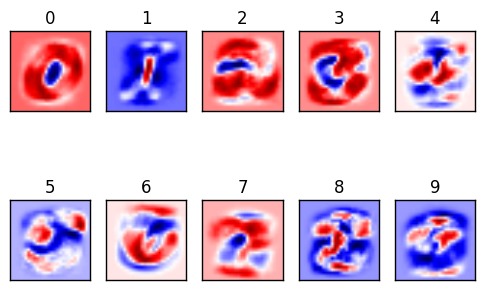

Model saved to ./models/one_layer.ckpt
CPU times: user 2.17 s, sys: 211 ms, total: 2.38 s
Wall time: 2.36 s


In [142]:
%%time
sess = tf.InteractiveSession()
# ONE LAYER
iter_ = data_iterator(train_digits, train_labels) 


# MODEL HERE 
x = tf.placeholder(tf.float32, [None, 784], name="input")
y_ = tf.placeholder(tf.float32, [None, 10])
# 10 weights to learn
w1 = tf.Variable(tf.zeros([784, 10]))
# 10 biases to learn
b1 = tf.Variable(tf.zeros([10]))    
z1 = tf.matmul(x, w1) + b1
y = tf.nn.softmax(z1, name="output")

init = tf.initialize_all_variables()
sess.run(init)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.2).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
init = tf.initialize_all_variables()
sess.run(init)

for _ in range(1000):
    batch_xs, batch_ys = iter_.next()
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

final = sess.run(accuracy, feed_dict={x:x_noisy_test[8] , y_: test_labels})
print final    
final = sess.run(accuracy, feed_dict={x:test_digits , y_: test_labels})
print final    

for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = sess.run(w1)[:,i]
    plt.title(i)
    plt.imshow(weight.reshape([28,28]), cmap=plt.get_cmap('seismic'))
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
plt.show()
    
saver = tf.train.Saver()
save_path = saver.save(sess, "./models/one_layer.ckpt")
print("Model saved to %s" % save_path)
tf.reset_default_graph()
sess = tf.InteractiveSession(config=tf.ConfigProto(inter_op_parallelism_threads=1,
                   intra_op_parallelism_threads=1))

# Naive Bayes

In [ ]:
# CREATE THE BAYES PRIORS
classifier_freq = np.ones(10, dtype=int)
pixel_freq = np.ones((28*28,10), dtype=int)

N = train_digits.shape[0]
D = train_digits.shape[1]

for i in range(N):
    c = np.where(train_labels[i] == 1)[0][0]
    classifier_freq[c] = classifier_freq[c] + 1 # = NC
    for j in range(28 * 28 -1):
        if train_digits[i][j] != 0:
            pixel_freq[j,c] = pixel_freq[j,c] + 1 # = NiC

#computing posterior means
theta_hat = np.zeros((28 * 28,10), dtype=float)
for c in range(10):
    for i in range(28*28):
        # we just use the pixel prescence, not intensity
        # 255
        theta_hat[i,c] = (theta_hat[i,c] + pixel_freq[i,c]) / classifier_freq[c]

In [ ]:
# here are our magnificient priors
plt.matshow(theta_hat[:,5].reshape(28,28))
plt.colorbar()
plt.show()
plt.matshow(theta_hat[:,8].reshape(28,28))
plt.colorbar()
plt.show()

In [ ]:
pi_hat = classifier_freq / float(N)
pi_hat_log = np.log(pi_hat)

theta_hat_log = np.log(theta_hat)

print type(theta_hat_log), type(theta_hat_log[0,0])

one_minus_theta_hat_log = np.log(1-theta_hat)

def posterior(pixels, threshold):
    lp = np.zeros(10)
    for c in range(10):
        lp[c] = lp[c] + pi_hat_log[c]
        for j in range (28 * 28):
            if pixels[j] > threshold:
                lp[c] = lp[c] + theta_hat_log[j,c]
            else:
                lp[c] = lp[c] + one_minus_theta_hat_log[j,c]
    return np.exp(lp) / sum(np.exp(lp))

def best_guess(pixels):
    guess = np.argmax(posterior(pixels,0.0))
    prob = posterior(pixels,0)[guess]
    return (guess, prob)

def test_label_guess(index, stddev):
    test = x_occ_test[stddev][index]
    label = np.where(test_labels[index] == 1)[0][0]
    (guess,prob) = best_guess(test)
    return (label,guess,prob)

test_label_guess(3,8)

In [ ]:
## DOESNT WORK WITH BAYES
# threshold. 
accs = []

for i in range(len(occ_percs)):
    counter = 0
    print occ_percs[i]
    # print x_noisy_test[i]
    for r in range(test_digits.shape[0]):
        (label,guess,prop) = test_label_guess(r, i)
        # if int(label) is not int(guess) and r < 20:
            # print r,i
            # print label,guess
            # plt.matshow(test_digits[r].reshape(28,28))
            # plt.colorbar()
            # plt.show()
        if int(label) == int(guess):
            counter = counter + 1
    
    print (float(counter) / test_digits.shape[0])
    accs.append((occ_percs[i],(float(counter) / test_digits.shape[0])))
    

In [ ]:
print accs

### theta_hat are the priors now, shape
### 784,10

# TWO LAYER FEEDBACK

### Two options (BELOW is number 2)

1) just make the feedback layer the same size as x (input) to resolve the size issue. Additionally i see that you compute the fb using z1, it should be z2 since thats the top layer.   
2) Or use the same fb and add it each individual unit of x. so if x is a vector of dimension 784 , use x1+fb,x2+fb .... f784+fb as the value.  

# LeCun 28x28->1000->10

## 2-layer NN, 1000 HU (28x28-1000-10) 13.4 secs

In [7]:
from collections import defaultdict

acc_trained_on_noisy = {}
weights_trained = {}

# E is skip from z1 to z3
''' 'A_2', 'A_3', '''
models = ['A_1', 'B', 'C', 'D', 'E']

# init dicts
for i in range(len(stddevs)):
    acc_trained_on_noisy[stddevs[i]] = {model: [] for model in models}

print acc_trained_on_noisy
    
for i in range(len(stddevs)):
    weights_trained[stddevs[i]] = {model: {'fb1000': 0, 'fb784': 0, 'skip': 0} for model in models}

# so for noise level 16
acc_trained_on_noisy[stddevs[1]]['A'] = 4
print acc_trained_on_noisy[stddevs[1]]
print acc_trained_on_noisy[stddevs[1]]['A']

configs = {'A_1': {'fb1000': False, 'fb784': False, 'skip': False}, 
           'A_2': {'fb1000': False, 'fb784': False, 'skip': False},
           'A_3': {'fb1000': False, 'fb784': False, 'skip': False},
           'B': {'fb1000': True, 'fb784': False, 'skip': False},
           'C': {'fb1000': False, 'fb784': True, 'skip': False}, 
           'D': {'fb1000': True, 'fb784': True, 'skip': False}, 
           'E': {'fb1000': False, 'fb784': False, 'skip': True}
          }

         
# GRAPH 1 = normal model with noise
# TRAIN ON NORMAL -> TEST ON NOISY
# GRAPH 2
# type 1 is feedback z3 + z2     plot fb weights
# type 2 is feedback z3 + z1     plot fb weights 
# two layers .... of shapes
# type 3 is feedback z3 + z2+ z3 + z2 plot fb weights

# For each ....
# TRAIN ON EVERY NOISE LEVEL -> TEST ON NOISY 
# type 0
# type 1 is feedback z3 + z2     plot fb weights
# type 2 is feedback z3 + z1     plot fb weights 
# type 3 is feedback z3 + z2+ z3 + z2 plot fb weights
# -> 13 different graphs

{0.0: {'C': [], 'B': [], 'E': [], 'D': [], 'A_1': []}, 48.0: {'C': [], 'B': [], 'E': [], 'D': [], 'A_1': []}, 112.0: {'C': [], 'B': [], 'E': [], 'D': [], 'A_1': []}, 32.0: {'C': [], 'B': [], 'E': [], 'D': [], 'A_1': []}, 80.0: {'C': [], 'B': [], 'E': [], 'D': [], 'A_1': []}, 64.0: {'C': [], 'B': [], 'E': [], 'D': [], 'A_1': []}, 128.0: {'C': [], 'B': [], 'E': [], 'D': [], 'A_1': []}, 160.0: {'C': [], 'B': [], 'E': [], 'D': [], 'A_1': []}, 192.0: {'C': [], 'B': [], 'E': [], 'D': [], 'A_1': []}, 96.0: {'C': [], 'B': [], 'E': [], 'D': [], 'A_1': []}, 16.0: {'C': [], 'B': [], 'E': [], 'D': [], 'A_1': []}, 144.0: {'C': [], 'B': [], 'E': [], 'D': [], 'A_1': []}, 176.0: {'C': [], 'B': [], 'E': [], 'D': [], 'A_1': []}}
{'A': 4, 'C': [], 'B': [], 'E': [], 'D': [], 'A_1': []}
4


In [523]:
## create the same batches during learning?

## precision recall??
## http://stackoverflow.com/questions/35365007/tensorflow-precision-recall-f1-score-and-confusion-matrix


96.0


In [ ]:
%%time

# models = ['A_1','B','C', 'D']
models = ['A_1','B','C']

stddev1=np.sqrt(1 / float(784))
# second = 10 units
stddev2=np.sqrt(1 / float(10))
stddev3=np.sqrt(1 / float(1000))

training_iters = 5
train_on_noisy = False
tr_size = 100
te_size = len(x_noisy_test[0])

# len (stddevs)
tf.reset_default_graph()


for i in range(7):
    print 'using training stddev ' + str(stddevs[i])
    # which data to train on?
    # NOISY 
    # iter_ = data_iterator(x_noisy_train[i], train_labels)     
    # CLEAN -> run only once
    iter_ = data_iterator(train_digits, train_labels)     
    
    for model in models:
        print 'evaluating model ' + str(model)
        
        use_fb1000 = configs[model]['fb1000']
        use_fb784 = configs[model]['fb784']
        use_skip = configs[model]['skip']
    
        # MODEL HERE 
        with tf.Graph().as_default():
            sess = tf.InteractiveSession(config=tf.ConfigProto(inter_op_parallelism_threads=1,
                           intra_op_parallelism_threads=1))
            x = tf.placeholder(tf.float32, [None, 784], name="input")
            noisy_x = tf.placeholder(tf.float32, [None, 784], name="input_noisy")
            z_3 = tf.placeholder(tf.float32, [None, 10], name="z3")
            batch_size = tf.placeholder(dtype=tf.int32)
            
            # blabla = tf.Variable(z_3,validate_shape=False)
            
            z_3 = tf.Variable(z_3, validate_shape=False)
                        
            y_ = tf.placeholder(tf.float32, [None, 10])
                                
            if (use_fb1000):  
                w_fb1000 = tf.get_variable('w_fb1000',[10,1000],
                                 initializer=tf.random_normal_initializer(mean=0, stddev=stddev3))
                b_fb1000 = tf.get_variable('b_fb1000',[1000,],
                                 initializer=tf.constant_initializer(0.0))
                
                # the first element here should be either 10000 for test or 100 for batches
                fb1000 = tf.matmul(z_3,w_fb1000) + b_fb1000
                # fb1000 = tf.matmul(w_fb1000,tf.ones([1000,10]))
                # print fb1000.get_shape()
                # fb1000 = 0
                # init fb1000
                # val = tf.constant(0, dtype=tf.float32)
                # fb1000 = tf.Variable(tf.fill(tf.shape(x), val), validate_shape=False)   
                #fb1000 = tf.get_variable('fb1000_',[100, 1000], 
                #                        initializer=tf.zeros_initializer)
                   
            if (use_fb784):
                w_fb784 = tf.get_variable('w_fb784',[10,784],
                                 initializer=tf.constant_initializer(0.0))
                b_fb784 = tf.get_variable('b_fb784',[784,],
                                 initializer=tf.constant_initializer(0.0))
                fb784 = 0
                
                
            w1 = tf.get_variable('w1',[784,1000],
                                 initializer=tf.random_normal_initializer(mean=0, stddev=stddev1))
            b1 = tf.get_variable('b1',[1000,],
                                 initializer=tf.constant_initializer(0.0))

            w2 = tf.get_variable('w2',[1000,1000],
                                 initializer=tf.random_normal_initializer(mean=0, stddev=stddev3))
            b2 = tf.get_variable('b2',[1000,],
                                 initializer=tf.constant_initializer(0.0))
            
            if model=='A_2':
                w_a2_1 = tf.get_variable('w_a2_1',[1000,256],
                                     initializer=tf.random_normal_initializer(mean=0, stddev=np.sqrt(1/float(1000))))
                b_a2_1 = tf.get_variable('b_a2_1',[256,],
                                     initializer=tf.constant_initializer(0.0))
                w_a2_2 = tf.get_variable('w_a2_2',[256,10],
                                     initializer=tf.random_normal_initializer(mean=0, stddev=np.sqrt(1/float(256))))                                                            
                b_a2_2 = tf.get_variable('b_a2_2',[10,],
                                     initializer=tf.constant_initializer(0.0))                                                                
            elif model=='A_3':
                w_a3_1 = tf.get_variable('w_a3_1',[1000,256],
                                     initializer=tf.random_normal_initializer(mean=0, stddev=np.sqrt(1/float(1000))))
                b_a3_1 = tf.get_variable('b_a3_1',[256,],
                                     initializer=tf.constant_initializer(0.0))
                w_a3_2 = tf.get_variable('w_a3_2',[256,128],
                                     initializer=tf.random_normal_initializer(mean=0, stddev=np.sqrt(1/float(256))))                                                           
                b_a3_2 = tf.get_variable('b_a3_2',[128,],
                                     initializer=tf.constant_initializer(0.0))
                w_a3_3 = tf.get_variable('w_a3_3',[128,10],
                                     initializer=tf.random_normal_initializer(mean=0, stddev=np.sqrt(1/float(128))))                                                             
                b_a3_3 = tf.get_variable('b_a3_3',[10,],
                                     initializer=tf.constant_initializer(0.0))
            else:
                w3 = tf.get_variable('w3',[1000,10],
                                 initializer=tf.random_normal_initializer(mean=0, stddev=stddev1))
                b3 = tf.get_variable('b3',[10,],
                                 initializer=tf.constant_initializer(0.0))
                
            if model == 'A_1' or model == 'A_2' or model == 'A_3' or model == 'B' or model == 'E':
                z1 =  tf.matmul(x, w1)+ b1 
            if model == 'C' or model == 'D':
                z1 =  tf.matmul(x+fb784, w1)+ b1

            y1 = tf.nn.relu(z1)
            
            if model == 'A_1' or model == 'A_2' or model == 'A_3' or model == 'C' or model == 'E':
                z2 = tf.matmul(y1, w2) + b2
            if model == 'B' or model == 'D':
                z2 = tf.matmul(y1+fb1000, w2) + b2
            
            # inbetween layers
            if model == 'A_2':
                y_3 = tf.nn.relu(z2)
                z4 = tf.matmul(y_3, w_a2_1) + b_a2_1
                y4 = tf.nn.relu(z4)
                # y4 = tf.nn.dropout(y4, 0.5)
                z5 = tf.matmul(y4, w_a2_2) + b_a2_2
            elif model == 'A_3':
                y_3 = tf.nn.relu(z2)
                z4 = tf.matmul(y_3, w_a3_1) + b_a3_1
                y4 = tf.nn.relu(z4)
                # y4 = tf.nn.dropout(y4, 0.5)
                z5 = tf.matmul(y4, w_a3_2) + b_a3_2
                y5 = tf.nn.relu(z5)
                # y5 = tf.nn.dropout(y5, 0.5)
                z6 = tf.matmul(y5, w_a3_3) + b_a3_3
            else:
                y2 = tf.nn.relu(z2) 
                if (use_skip):
                    # print "using skip"
                    w_skip = tf.get_variable('w_skip',[784,10],
                                     initializer=tf.random_normal_initializer(mean=0, stddev=stddev1))
                    b_skip = tf.get_variable('b_skip',[10,],
                                     initializer=tf.constant_initializer(0.0))    
                    # skip from input to output
                    z_skip = tf.matmul(x, w_skip) + b_skip
                    z3 = tf.matmul(y2, w3) + b3  + z_skip
                else:
                    z3 = tf.matmul(y2, w3) + b3 
                    
            blabla = z3
            
            '''
            # handle feedbacks
            # INTRODUCE NON LINEARITY?
            if model == 'B' or model == 'D':
                # + tf.nn.relu ?
                # z3 here instead of noisy_x -> change shapes as well of weights
                # fb1000 = tf.matmul(z3,w_fb1000) + b_fb1000
                print "hi"

            if model == 'C' or model == 'D':
                # + tf.nn.relu ?
                # 
                fb784 = tf.nn.relu(tf.matmul(z3,w_fb784) + b_fb784)
                print fb784.get_shape()
            '''
            
            
            if model == 'A_1' or model == 'B' or model == 'C' or model == 'D' or model == 'E':
                # output
                y = tf.nn.softmax(z3, name="output")
            elif model == 'A_2':
                y = tf.nn.softmax(z5, name="output")
            elif model == 'A_3': 
                y = tf.nn.softmax(z6, name="output")
                
            print [bla.name for bla in tf.trainable_variables()]
            init = tf.initialize_all_variables()
            sess.run(init)
 
            # add small number to prevent weight decays
            cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.clip_by_value(y,1e-10,1.0)), reduction_indices=[1]))
            if train_on_noisy:
                train_step = tf.train.GradientDescentOptimizer(0.2).minimize(cross_entropy,var_list=[w1,w2,w3,b1,b2,b3])
                if model == 'B':
                    train_step_fb_b = tf.train.GradientDescentOptimizer(0.2).minimize(cross_entropy, var_list=[w_fb1000, b_fb1000])
                if model == 'C':
                    train_step_fb_c = tf.train.GradientDescentOptimizer(0.2).minimize(cross_entropy, var_list=[w_fb784, b_fb784])
                if model == 'D':
                    train_step_fb_d = tf.train.GradientDescentOptimizer(0.2).minimize(cross_entropy, var_list=[w_fb1000, b_fb1000,w_fb784, b_fb784])
            else:
                train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

            correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

            init = tf.initialize_all_variables()
            sess.run(init)

            cost_history=[]

            # print [bla.name for bla in tf.trainable_variables()]
            
            fb_last = 0
            # init initial feedback to zero
            for j in range(training_iters):  
                batch_xs, batch_ys = iter_.next()
                # if model == 'B' or model == 'D':
                    # weights are updated
                    # print "bla"
                    # print w_fb1000.eval(sess)
                    # print z3.eval(feed_dict={x: batch_xs, y_: batch_ys, noisy_x: noisy_batch, batch_size: tr_size}).shape


                    # biases not updated
                    #  print b_fb1000.eval(sess)

                    # print fb1000.eval(feed_dict={x: batch_xs, y_: batch_ys, noisy_x: noisy_batch, batch_size: tr_size})
                    # this changes
                    # print fb_last
                
                #if model == 'C' or model == 'D':
                    # print fb784.eval(feed_dict={x: batch_xs, y_: batch_ys, noisy_x: noisy_batch, batch_size: tr_size})
                    # print w_fb784.eval(sess)
                
                # batch needs to be noised as well TRAIN FEEDBACK ON NOISE 
                # switch off if not applicable
                if (model== 'B' or model =='C' or model == 'D') and train_on_noisy:
                    noisy_batch = add_gaussian_noise(batch_xs, 0, stddevs[i])
                else:
                    noisy_batch = np.zeros([100,784])
               
                print j
               
                # cost_history = np.append(cost_history,sess.run(cross_entropy,feed_dict={x: batch_xs, noisy_x: noisy_batch, y_: batch_ys, batch_size: tr_size}))
                # BATCHXS IS CLEAN, NOISY BATCH USED FOR PRIOR
                if j == 0:
                    print "0"
                    # xds = z_3.eval(sess)                
                else:
                    print "else"
                    # xds = z_3.eval(sess)
                
                sess.run(train_step, feed_dict={x: batch_xs, z_3:xds, noisy_x: noisy_batch, y_: batch_ys, batch_size: tr_size})
                
                
                
                if train_on_noisy:
                    if model == 'B':
                        sess.run(train_step_fb_b, feed_dict={x: noisy_batch, noisy_x: noisy_batch, y_: batch_ys, batch_size: tr_size})
                    if model == 'C':
                        sess.run(train_step_fb_c, feed_dict={x: noisy_batch, noisy_x: noisy_batch, y_: batch_ys, batch_size: tr_size})
                    if model == 'D':
                    # fix feedforward weights, train on noisy
                        sess.run(train_step_fb_d, feed_dict={x: noisy_batch, noisy_x: noisy_batch, y_: batch_ys, batch_size: tr_size})
                    
            # plt.plot(range(len(cost_history)),cost_history)
            # plt.show()
            # store weights
            '''
            if (use_fb784):
                weights_trained[stddevs[i]][model]['fb784'] = w_fb784.eval(sess)
            if (use_fb1000):
                weights_trained[stddevs[i]][model]['fb1000'] = w_fb1000.eval(sess)
            if (use_skip):
                weights_trained[stddevs[i]][model]['skip'] = w_skip.eval(sess)
            '''
            
            
            current_accuracies = []
            # final = sess.run(accuracy, feed_dict={x: test_digits, noisy_x:x_noisy_test[k], y_: test_labels, batch_size: te_size})
            # print final
            # use k here because i,j are already taken
            # z3_ = np.zeros([te_size, 10], dtype=np.float32)
            for k in range(len(stddevs)):
                final = sess.run(accuracy, feed_dict={x: x_noisy_test[k], noisy_x:x_noisy_test[k], y_: test_labels, batch_size: te_size})
                # print stddevs[i], final
                current_accuracies.append(final)   

            # print final
            # append to noise val and model
            # print "appending accuracies for model " +str(model)
            print current_accuracies
            # print acc_trained_on_noisy[stddevs[i]]
            # print stddevs[i]
            acc_trained_on_noisy[stddevs[i]][model] = current_accuracies
    
    '''
    saver = tf.train.Saver()
    if skip == True and feedback == False:
        save_path = saver.save(sess, "./models/lecun_skip.ckpt")
    elif skip == True and feedback == True:
        save_path = saver.save(sess, "./models/lecun_skip_fb.ckpt")
    elif skip == False and feedback == True:
        save_path = saver.save(sess, "./models/lecun_fb.ckpt")   
    else:
        save_path = saver.save(sess, "./models/lecun.ckpt")

    print("Model saved to %s" % save_path)

    for i in range(10):
        plt.subplot(2, 5, i+1)
        weight = sess.run(w_skip)[:,i]
        plt.title(i)
        plt.imshow(weight.reshape([28,28]) , cmap=plt.get_cmap('seismic'))
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
    for i in range(10):
        plt.subplot(2, 5, i+1)
        weight = sess.run(w2)[:,i]
        plt.title(i)
        print(weight.shape)
        plt.imshow(weight.reshape([32,32]), cmap=plt.get_cmap('seismic'))
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
        
    
plt.colorbar()
plt.subplots_adjust(hspace=0.01)
plt.show()
        
tf.reset_default_graph()
sess = tf.InteractiveSession(config=tf.ConfigProto(inter_op_parallelism_threads=1,
                       intra_op_parallelism_threads=1))
'''




In [ ]:
## %%time

models= ['A_1','B','C','D','E']

stddev1=np.sqrt(2 / float(784))
# second = 10 units
stddev2=np.sqrt(2 / float(10))
stddev3=np.sqrt(2 / float(1000))

training_iters = 500
tr_size = 100
te_size = len(x_noisy_test[0])

for i in range(len(stddevs)):
    print 'using training stddev ' + str(stddevs[i])
    # which data to train on?
    iter_ = data_iterator(x_noisy_train[i], train_labels) 
    
    tf.reset_default_graph()
    
    
    for model in models:
        print 'evaluating model ' + str(model)
        
        use_fb1000 = configs[model]['fb1000']
        use_fb784 = configs[model]['fb784']
        use_skip = configs[model]['skip']
        
        # MODEL HERE 
        with tf.Graph().as_default():
            sess = tf.InteractiveSession(config=tf.ConfigProto(inter_op_parallelism_threads=1,
                           intra_op_parallelism_threads=1))
            # sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))

            x = tf.placeholder(tf.float32, [None, 784], name="input")                        
            batch_size = tf.placeholder(dtype=tf.int32)

            fb_place = tf.placeholder(tf.float32, [None, 10], name='fbplace')
            fb_place.set_shape([None, 10])
            train = tf.placeholder(dtype=tf.bool)

            y_ = tf.placeholder(tf.float32, [None, 10])

            if (use_fb1000):  
                w_fb1000 = tf.get_variable('w_fb1000',[10,1000],
                                 initializer=tf.random_normal_initializer(mean=0, stddev=stddev3))
                b_fb1000 = tf.get_variable('b_fb1000',[1000,],
                                 initializer=tf.constant_initializer(0.0))
                # fb1000 = tf.zeros([batch_size, 1000])

                # the first element here should be either 10000 for test or 100 for batches
                fb1000 = tf.nn.relu(tf.matmul(fb_place, w_fb1000) + b_fb1000)
                # print fb1000.get_shape()

                # init fb1000
                # val = tf.constant(0, dtype=tf.float32)
                # fb1000 = tf.Variable(tf.fill(tf.shape(x), val), validate_shape=False)   
                # fb1000 = tf.get_variable('fb1000_',[batch_size, 1000], 
                #                        initializer=tf.zeros_initializer)

            if (use_fb784):
                w_fb784 = tf.get_variable('w_fb784',[10,784],
                                 initializer=tf.random_normal_initializer(mean=0, stddev=stddev1))
                b_fb784 = tf.get_variable('b_fb784',[784,],
                                 initializer=tf.constant_initializer(0.0))
                fb784 = tf.nn.relu(tf.matmul(fb_place, w_fb784) + b_fb784)


            w1 = tf.get_variable('w1',[784,1000],
                                 initializer=tf.random_normal_initializer(mean=0, stddev=stddev1))
            b1 = tf.get_variable('b1',[1000,],
                                 initializer=tf.constant_initializer(0.0))

            if model == 'A_1' or model == 'B' or model == 'E':
                z1 =  tf.matmul(x, w1)+ b1 
            if model == 'C' or model == 'D':
                # if train == true, if train == false
                z1 = tf.cond(train, lambda: tf.add(tf.matmul(x+fb784,w1), b1), lambda: tf.add(tf.matmul(x+fb784-fb784,w1), b1))

            y1 = tf.nn.relu(z1)

            w2 = tf.get_variable('w2',[1000,1000],
                                 initializer=tf.random_normal_initializer(mean=0, stddev=stddev3))
            b2 = tf.get_variable('b2',[1000,],
                                 initializer=tf.constant_initializer(0.0))

            if model == 'A_1' or model == 'C' or model == 'E':
                z2 = tf.matmul(y1, w2) + b2
            if model == 'B' or model == 'D':
                # z2 = tf.matmul(y1+fb1000, w2) + b2
                z2 = tf.cond(train, lambda: tf.add(tf.matmul(y1+fb1000,w2), b2), lambda: tf.add(tf.matmul(y1+fb1000-fb1000,w2), b2))

            y2 = tf.nn.relu(z2)

            w3 = tf.Variable(tf.zeros([1000, 10]))
            b3 = tf.Variable(tf.zeros([10]))

            if (use_skip):
                print "using skip"
                w_skip = tf.get_variable('w_skip',[784,10],
                                 initializer=tf.random_normal_initializer(mean=0, stddev=stddev1))
                b_skip = tf.get_variable('b_skip',[10,],
                                 initializer=tf.constant_initializer(0.0))

            if (use_skip):
                # skip from input to output
                z_skip = tf.matmul(x, w_skip) + b_skip
                z3 = tf.matmul(y2, w3) + b3  + z_skip
            else:
                z3 = tf.matmul(y2, w3) + b3

            # handle feedbacks
            '''# INTRODUCE NON LINEARITY?
            if model == 'B' or model == 'D':
                # + tf.nn.relu ?
                fb1000 = tf.matmul(z3,w_fb1000) + b_fb1000
            if model == 'C' or model == 'D':
                # + tf.nn.relu ?
                fb784 = tf.nn.relu(tf.matmul(z3,w_fb784) + b_fb784)'''

            # output
            y = tf.nn.softmax(z3, name="output")

            cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
            train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

            correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

            init = tf.initialize_all_variables()
            sess.run(init)
            cost_history=[]

            fb_last = 0
            # init initial feedback to zero
            for j in range(training_iters):   
                batch_xs, batch_ys = iter_.next()
                # if model == 'B' or model == 'D':
                    # weights are updated
                    # print w_fb1000.eval(sess)
                    # biases not updated
                    #  print b_fb1000.eval(sess)

                    # fb_last = fb1000.eval(feed_dict={x: batch_xs, y_: batch_ys})
                    # this changes
                    # print fb_last

                # if model == 'C' or model == 'D':
                    # fb_last = fb784.eval(feed_dict={x: batch_xs, y_: batch_ys})
                    # print fb_last

                if j == 0:
                    if model == 'B':
                        state = np.random.normal(0, np.sqrt(1.0/1000.0), (tr_size, 10))     
                    else:
                        state = np.random.normal(0, np.sqrt(1.0/784.0), (tr_size, 10))
    
                out, state = sess.run([train_step, z3], feed_dict={train: True, x: batch_xs, fb_place:state, y_: batch_ys, batch_size: tr_size})

            # store weights
            if (use_fb784):
                weights_trained[stddevs[i]][model]['fb784'] = w_fb784.eval(sess)
            if (use_fb1000):
                weights_trained[stddevs[i]][model]['fb1000'] = w_fb1000.eval(sess)
            if (use_skip):
                weights_trained[stddevs[i]][model]['skip'] = w_skip.eval(sess)

            current_accuracies = []
            # use k here because i,j are already taken
            state = np.zeros((te_size, 10))
            for k in range(len(stddevs)):
                final = sess.run(accuracy, feed_dict={train: False, x:x_noisy_test[k], fb_place: state , y_: test_labels, batch_size: te_size})
                # print stddevs[i], final
                current_accuracies.append(final)

            # append to noise val and model
            # print "appending accuracies for model " +str(model)
            print current_accuracies
            # print acc_trained_on_noisy[stddevs[i]]
            # print stddevs[i]
            acc_trained_on_noisy[stddevs[i]][model] = current_accuracies

using training stddev 0.0
evaluating model A_1
[0.96789998, 0.96380001, 0.95060003, 0.90700001, 0.81650001, 0.7022, 0.61510003, 0.53860003, 0.47369999, 0.41060001, 0.37639999, 0.34369999, 0.31799999]
evaluating model B
[0.96170002, 0.9594, 0.94700003, 0.90899998, 0.8143, 0.71179998, 0.62470001, 0.5503, 0.49360001, 0.44049999, 0.39610001, 0.3617, 0.33399999]
evaluating model C
[0.95819998, 0.95770001, 0.94980001, 0.94160002, 0.92269999, 0.88380003, 0.83090001, 0.75160003, 0.676, 0.59399998, 0.53179997, 0.48140001, 0.4287]
evaluating model D
[0.95240003, 0.94910002, 0.94389999, 0.93739998, 0.92140001, 0.89709997, 0.85610002, 0.7863, 0.7184, 0.64450002, 0.58499998, 0.52100003, 0.47139999]
evaluating model E
using skip
[0.96340001, 0.95700002, 0.93279999, 0.87269998, 0.76429999, 0.63919997, 0.54250002, 0.4729, 0.4262, 0.3836, 0.34779999, 0.3184, 0.2965]
using training stddev 16.0
evaluating model A_1
[0.9673, 0.9648, 0.95910001, 0.94199997, 0.90280002, 0.81449997, 0.69480002, 0.57230002, 0

In [21]:
noisy_train_eval_noisy = acc_trained_on_noisy.copy()

## PLOTTING WEIGHTS

In [ ]:
# feedback weights are of size 10 though and len(100)

for j in range(len(stddevs)):
    # skip goes from 784 -> 10 so size is 784
    plt.suptitle('Std Dev ' + str(stddevs[j]))
    plt.figure(figsize=(2, 9))

    for i in range(10):
        plt.subplot(10, 1, i+1)
        weight = weights_trained[stddevs[j]]['E']['skip'][:,i]
        plt.imshow(weight.reshape([28,28]) , cmap=plt.get_cmap('seismic'))
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
    plt.savefig("skip_priors/plt_"+str(stddevs[j])+".png", bbox_inches="tight");

In [ ]:
for i in range(10):
    plt.subplot(10, 1, i+1)
    weight = weights_trained[stddevs[0]]['D']['fb1000'][:,i]
    plt.imshow(weight.reshape([28,28]) , cmap=plt.get_cmap('seismic'))
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

## PLOTTING ACCURACIES

In [448]:
table_accs = {'A_1': [], 'B': [], 'C':[], 'D':[]}

def average(nums, default=float('nan')):
    return sum(nums) / float(len(nums)) if nums else default

table_models = ['A_1', 'B', 'C', 'D']

# all accs
for i in range(7):
    for model in table_models:
        table_accs[model].append(acc_trained_on_noisy[stddevs[i]][model][0:7])
        # get until 96

# for latex
for model in table_models:
    print model
    accs = [str(round(average(n),3)) for n in zip(*table_accs[model])]
    print ' & '.join(accs)


A_1
0.952 & 0.95 & 0.945 & 0.935 & 0.902 & 0.844 & 0.764
B
0.956 & 0.955 & 0.953 & 0.947 & 0.932 & 0.907 & 0.86
C
0.958 & 0.958 & 0.954 & 0.948 & 0.936 & 0.911 & 0.87
D
0.957 & 0.956 & 0.953 & 0.947 & 0.935 & 0.911 & 0.869


In [32]:
# DONT OVERRIDE THIS TO PLOT LATER
# this is priors trained on noisy
# ff on clean
# can also add new keys here such as A_2 and A_3


NameError: name 'test_5' is not defined

In [31]:
# this is with noisy feedbacks and clean ff


NameError: name 'test_6' is not defined

In [30]:
# trained on clean, eval on noisy
# only first of acc is necessary


NameError: name 'test_4' is not defined

In [ ]:
# both trained on noisy
# eval on noisy
test_3

IOError: [Errno 2] No such file or directory: 'ff_clean_fb_clean/plot_0.png'

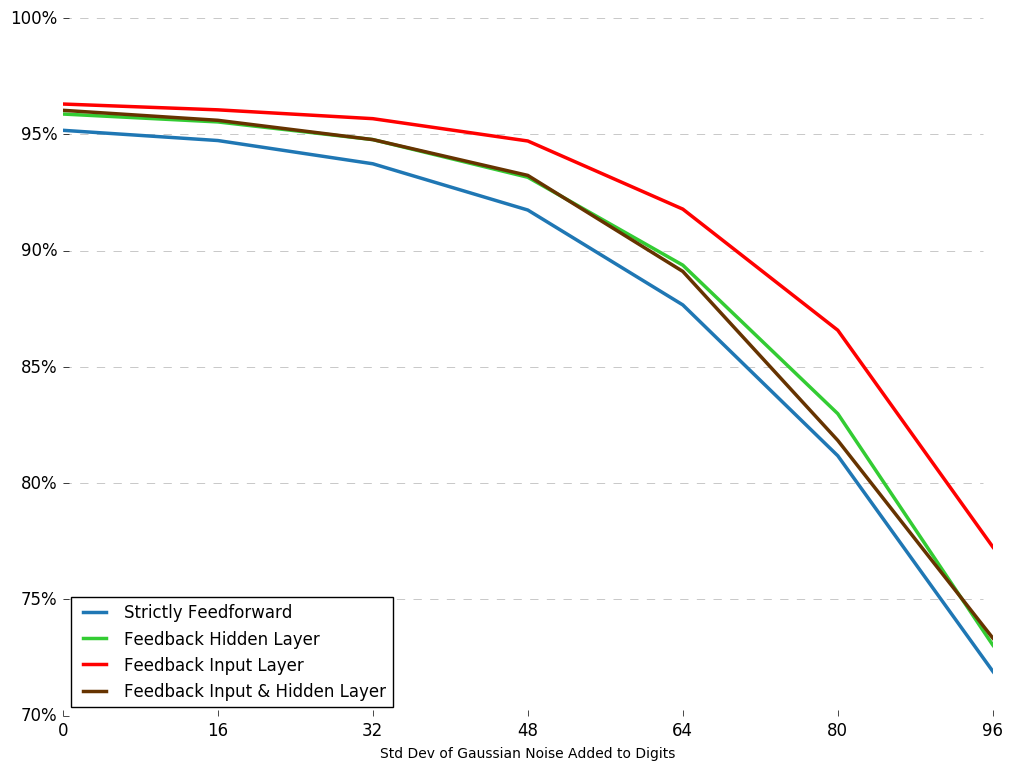

In [468]:
import matplotlib.pyplot as plt  
 
# These are the "Tableau 20" colors as RGB.
tableau4 = [(31, 119, 180), (51, 204, 51), (255, 0, 0), (102, 51, 0), (0, 0, 255)]

def RepresentsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau4)):
    r, g, b = tableau4[i]
    tableau4[i] = (r / 255., g / 255., b / 255.)

# 'Type A_2', 'Type A_3'
types = ['A_1', 'B', 'C', 'D'] # 'E']

for i in range(1):# len(stddevs)):
    plt.figure(figsize=(12, 9))

    # Remove the plot frame lines. They are unnecessary chartjunk.
    ax = plt.subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Ensure that the axis ticks only show up on the bottom and left of the plot.
    # Ticks on the right and top of the plot are generally unnecessary chartjunk.
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    # Limit the range of the plot to only where the data is.
    # Avoid unnecessary whitespace.
    plt.ylim(70, 100)
    plt.xlim(0, 96)
    plt.xlabel('Std Dev of Gaussian Noise Added to Digits')

    # Make sure your axis ticks are large enough to be easily read.
    # You don't want your viewers squinting to read your plot.
    plt.yticks(range(70, 101, 5), [str(x) + "%" for x in range(70, 101, 5)], fontsize=12)
    plt.xticks(stddevs[:7], fontsize=12)

    # Provide tick lines across the plot to help your viewers trace along
    # the axis ticks. Make sure that the lines are light and small so they
    # don't obscure the primary data lines.
    for y in range(70, 101, 5):
        plt.plot([y] * len(range(0, 96)), "--", lw=0.5, color="black", alpha=0.3)

    # Remove the tick marks; they are unnecessary with the tick lines we just plotted.
    plt.tick_params(axis="both", which="both", bottom="on", top="off",
                    labelbottom="on", left="on", right="off", labelleft="on")

    for rank, column in enumerate(types):
        # Plot each line separately with its own color, using the Tableau 20
        # color set in order.

        # so all the stddevs = gender_degree_data.Year.values
        # = 16 : A
        # print test_data[stddevs[1]][column[-1]]
        # print column[-1]    
        # accuracies are 0....
        
        if column == 'A_1':
            label = 'Strictly Feedforward'
        if column == 'A_2':
            label = '784-1000-256-10 FF Only'
        if column == 'A_3':
            label = '784-1000-256-128-10 FF Only'
        if column == 'B':
            label = 'Feedback Hidden Layer'
        if column == 'C':
            label = 'Feedback Input Layer'
        if column == 'D':
            label = 'Feedback Input & Hidden Layer'
        if column == 'E':
            label = '784-1000-10 FF + Skip'
        
        # deal with A_1, A_2, A_3
        plt.plot(stddevs,
                 # first_expression if bool_expression_is_true else second_expression
                np.multiply(test_5[stddevs[i]]['A_'+column[-1] if RepresentsInt(column[-1]) else column[-1]], 100),
                lw=2.5, color=tableau4[rank], label=label)
 
        # Add a text label to the right end of every line. Most of the code below
        # is adding specific offsets y position because some labels overlapped.
        # this is the last val
        y_pos = acc_trained_on_noisy[stddevs[i]]['A_'+column[-1] if RepresentsInt(column[-1]) else column[-1]][-1]*100

        # Again, make sure that all labels are large enough to be easily read
        # by the viewer.
        # plt.title(' Feedforward Trained on Clean Digits, Feedbacks with Deviation: ' + str(stddevs[i])) 
        # plt.title('Feedforwards Trained on Clean, Feedbacks Trained on Noisy Digits With Std. Dev. ' +str(int(stddevs[i])))
        
        plt.legend(loc=3)
        # plt.text(192, y_pos, column, fontsize=12, color=tableau4[rank])
        
    plt.savefig("ff_clean_fb_clean/plot_"+str(int(stddevs[i]))+".png", bbox_inches="tight");



In [ ]:
main argument for feedback: prior is reinforcement
gap : evaluate on noisy digits

In [ ]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

num_epochs = 5
total_series_length = len(train_digits)
truncated_backprop_length = 10
state_size = 784
num_classes = 10
echo_step = 3
batch_size = 100
num_batches = total_series_length//batch_size//truncated_backprop_length


def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
print(W.get_shape())
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

# Unpack columns
inputs_series = tf.unpack(batchX_placeholder, axis=1)
labels_series = tf.unpack(batchY_placeholder, axis=1)

# Forward pass
current_state = init_state
states_series = []
for current_input in inputs_series:
    current_input = tf.reshape(current_input, [batch_size, 1])
    input_and_state_concatenated = tf.concat(1, [current_input, current_state])  # Increasing number of columns

    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    states_series.append(next_state)
    current_state = next_state

logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)


with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        
        x,y = iter_.next()
        _current_state = np.zeros((batch_size, state_size))

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length
            print(start_idx)
            print(end_idx)
            
            print(x.shape,y.shape)
            
            print(y[10:20])
            
            batchX = x[start_idx:end_idx]
            batchY = y[start_idx:end_idx]
            
            print(batchY.shape)
            print(batchX.shape)
            
            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()



### RELU 

In [ ]:
%%time
iter_ = data_iterator(train_digits, train_labels)      
# could also change this to 784, 256 ->  256, 256-> 256, 10
# http://stackoverflow.com/questions/41993311/adding-more-layers-to-tensorflow-mnist-tutorial-makes-accuracy-drop                          
# but that would be unfair comparison
# relu init http://cs231n.github.io/neural-networks-2/ -> relu bias 

x = tf.placeholder(tf.float32, [None, 784], name="input")

W = tf.Variable(tf.random_normal([784, 256], stddev=0.1)) 
W1 = tf.Variable(tf.random_normal([256, 256], stddev=0.1))
W2 = tf.Variable(tf.random_normal([256, 10], stddev=0.1))
b = tf.Variable(tf.zeros([256]))
b1 = tf.Variable(tf.zeros([256]))
b2 = tf.Variable(tf.zeros([10]))

y = tf.matmul(x, W) + b
y = tf.nn.relu(y)
y = tf.matmul(y, W1) + b1
y = tf.nn.relu(y)
y = tf.nn.softmax(tf.matmul(y, W2) + b2, name="output")

y_ = tf.placeholder(tf.float32, [None, 10])

init = tf.initialize_all_variables()
sess.run(init)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
# use gradient descent just because.
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

# evals
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.initialize_all_variables()
sess.run(init)

for _ in range(1000):
    batch_xs, batch_ys = iter_.next()  #mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})


final = sess.run(accuracy, feed_dict={x: x_noisy, y_: test_labels})
print final 
final = sess.run(accuracy, feed_dict={x: test_digits, y_: test_labels})
print final

saver = tf.train.Saver()
save_path = saver.save(sess, "./models/relu.ckpt")
print("Model saved to %s" % save_path)

tf.reset_default_graph()
sess = tf.InteractiveSession()


# SQUARED

In [ ]:
%%time

tf.reset_default_graph()
sess = tf.InteractiveSession()


iter_ = data_iterator(x_noisy_train[6], train_labels)      
# MODEL HERE 
##
x = tf.placeholder(tf.float32, [None, 784], name="input")
# 764 weights to learn
w1 = tf.Variable(tf.zeros([784, 10]))
# 10 biases to learn
b1 = tf.Variable(tf.zeros([10]))    
y = tf.nn.softmax(tf.matmul(x, w1) + b1, name="output")

y_ = tf.placeholder(tf.float32, [None, 10])

init = tf.initialize_all_variables()
sess.run(init)

'''THIS CHANGES FROM THE ONE LAYER MODEL'''
cross_entropy = tf.reduce_mean(tf.square(y - y_))
##
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.initialize_all_variables()
sess.run(init)

for _ in range(1000):
    batch_xs, batch_ys = iter_.next()  #mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

plt.suptitle('Single_lyr_sqr Priors on Clean Digits')
plt.figure(figsize=(2, 9))

for i in range(10):
    plt.subplot(10, 1, i+1)
    weight = sess.run(w1)[:,i]
    # plt.title(i)
    plt.imshow(weight.reshape([28,28]), cmap=plt.get_cmap('seismic'))
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
plt.show()

final = sess.run(accuracy, feed_dict={x: test_digits, y_: test_labels})
print final

saver = tf.train.Saver()
save_path = saver.save(sess, "./models/one_layer_sqr.ckpt")
print("Model saved to %s" % save_path)
tf.reset_default_graph()
sess = tf.InteractiveSession()

## CONVNET

In [ ]:
# tensorflow
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

iter_ = data_iterator(train_digits, train_labels)      

x = tf.placeholder(tf.float32, shape=[None, 784], name="input")
y_ = tf.placeholder(tf.float32, shape=[None, 10])

W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1,28,28,1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# decrease ConvNet to 1 layer
# 2 layer apply prior from output to input
# doesnt solve the noise by adding more parameters
# single layer expansion + feedback

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32, name="keep_prob")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, name="output")

init = tf.initialize_all_variables()
sess.run(init)

cross_entropy = tf.reduce_mean(
tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.initialize_all_variables()
sess.run(init)

# train 1000 batches of size 100 (defined in iterator function)
for _ in range(1000):
    batch_xs, batch_ys = iter_.next() 
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
    
# evaluation
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
final = sess.run(accuracy, feed_dict={x: test_digits, y_: test_labels, keep_prob: 1.0})
print final

saver = tf.train.Saver()
save_path = saver.save(sess, "./models/conv.ckpt")
print("Model saved to %s" % save_path)
tf.reset_default_graph()
sess = tf.InteractiveSession()


## Bidirectional rnn

In [ ]:
# Parameters
learning_rate = 0.001
training_iters = 100000
batch_size = 100
display_step = 10

# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
x = tf.placeholder(tf.float32, [None, n_steps, n_input], name="input")
y_ = tf.placeholder(tf.float32, [None, n_classes])

# Define weights
weights = {
    # Hidden layer weights => 2*n_hidden because of foward + backward cells
    'out': tf.Variable(tf.random_normal([2*n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [ ]:
%%time
# https://github.com/aymericdamien/TensorFlow-Examples
from tensorflow.contrib import rnn
def BiRNN(x, weights, biases):

    # Prepare data shape to match `bidirectional_rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)
    
    # unstack v1.0.0 so we use unpack
    # Unpack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unpack(x, n_steps, 1)

    # Define lstm cells with tensorflow
    # Forward direction cell
    with tf.variable_scope('forward', reuse=True):
        lstm_fw_cell  = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    with tf.variable_scope('backward', reuse=True):
        lstm_bw_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)

    # Get lstm cell output
    try:
        with tf.variable_scope('outputs_2',reuse=None):
            outputs, _, _ = tf.nn.bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                                  dtype=tf.float32)
    except Exception: # Old TensorFlow version only returns outputs not states
        with tf.variable_scope('outputs',reuse=None):    
            outputs = tf.nn.bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                            dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    # NAME FOR SAVING
    return tf.add(tf.matmul(outputs[-1], weights['out']), biases['out'], name="output")

sess.close()
sess = tf.InteractiveSession()

pred = BiRNN(x, weights, biases)

print type(pred)
print pred


init = tf.initialize_all_variables()
sess.run(init)


# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.initialize_all_variables()
sess.run(init)

step = 0
while step * batch_size < training_iters:
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    # Reshape data to get 28 seq of 28 elements
    batch_x = batch_x.reshape((batch_size, n_steps, n_input))
    # Run optimization op (backprop)
    sess.run(optimizer, feed_dict={x: batch_x, y_: batch_y})
    
    # to check if the training improves
    # if step % display_step == 0:
        # print sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
    step+=1

# calculate accuracy on 256 digits
test_len = 256
# remember to reshape
test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
test_labels = mnist.test.labels[:test_len]

print sess.run(accuracy, feed_dict={x: test_data, y_: test_labels})
saver = tf.train.Saver()
save_path = saver.save(sess, "./models/birnn.ckpt")
print("Model saved to %s" % save_path)
tf.reset_default_graph()
sess = tf.InteractiveSession()

    

In [ ]:
mnist.test.images[4:10].reshape((-1, n_steps, n_input)).shape

In [ ]:
'''MAYBE USEFUL LATER'''
'''
print "validation accuracy:", val_accuracy
y_true = np.argmax(test_label,1)
print "Precision", sk.metrics.precision_score(y_true, y_pred)
print "Recall", sk.metrics.recall_score(y_true, y_pred)
print "f1_score", sk.metrics.f1_score(y_true, y_pred)
print "confusion_matrix"
print sk.metrics.confusion_matrix(y_true, y_pred)
fpr, tpr, tresholds = sk.metrics.roc_curve(y_true, y_pred)
'''